In [1]:
from PIL import Image
from numpy import asarray
import numpy as np
import params
from CentroidTracker import CentroidTracker, progressBar, showWindows, georeference
import cv2

from model import DeepLabModel, DeepLab

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [2]:
def create__label_colormap():
     return np.asarray([
         [0, 0, 0],
         [0, 192, 0],
         [255, 192, 192],
     ])
    
def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
    label: A 2D array with integer type, storing the segmentation label.

    Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

    Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create__label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [3]:
ct = CentroidTracker()

model = DeepLabModel('model/frozen_inference_graph_cars.pb')

In [4]:
file = str('input/foto/cars.JPG')
original_im = Image.open(file)

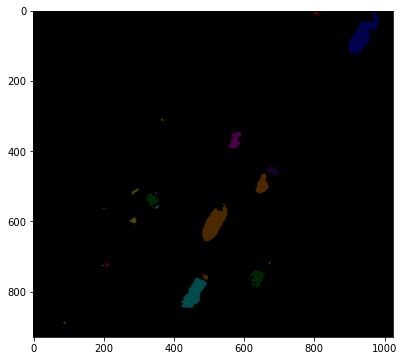

In [13]:
mask = model.run(original_im)

image_array = np.array(mask)

# apply threshold
thresh = threshold_otsu(image_array)
bw = closing(image_array > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image_array, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

# --- Generate Boundingboxes
# for region in regionprops(label_image):
#     # take regions with large enough areas
#     if region.area >= 100:
#         # draw rectangle around segmented coins
#         minr, minc, maxr, maxc = region.bbox
#         rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
#                                   fill=False, edgecolor='red', linewidth=2)
#         ax.add_patch(rect)


#set a thresh
thresh = 100
#get threshold image
ret,thresh_img = cv2.threshold((image_array*165).astype('float'), thresh, 255, cv2.THRESH_BINARY)
#find contours
contours, hierarchy = cv2.findContours(thresh_img.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#create an empty image for contours
img_contours = np.zeros(image_array.shape)
# draw the contours on the empty image
cv2.drawContours(img_contours, contours, -1, 255, 3)

rects = []
ROI_number = 0
for cntr in contours:
    x, y, w, h = cv2.boundingRect(cntr)
    if params.min_width < w < params.max_width and params.min_height < h < params.max_height:
        cv2.rectangle(img_contours, (x, y), (x + w, y + h), (0, 0, 255), 2)
        ROI = img_contours[y:y + h, x:x + w]
        cv2.putText(image_label_overlay, str(ROI_number), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))
        rects.append([x, y, x + w, y + h])
        ROI_number += 1

objects, life = ct.update(rects)